<a href="https://colab.research.google.com/github/Khawla10/GitForProgrammers/blob/main/Copy_of_Jax_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX As Accelerated NumPy


## Getting started with JAX numpy

Fundamentally, JAX is a library that enables transformations of array-manipulating programs written with a NumPy-like API. 

Over the course of this series of guides, we will unpack exactly what that means. For now, you can think of JAX as *differentiable NumPy that runs on accelerators*.

The code below shows how to import JAX and create a vector.

In [ ]:
import jax
import jax.numpy as jnp
x = jnp.arange(10)
print(x)

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


So far, everything is just like NumPy. A big appeal of JAX is that you don't need to learn a new API. Many common NumPy programs would run just as well in JAX if you substitute `np` for `jnp`. However, there are some important differences which we touch on at the end of this section.

You can notice the first difference if you check the type of `x`. It is a variable of type `DeviceArray`, which is the way JAX represents arrays.

In [ ]:
x

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

One useful feature of JAX is that the same code can be run on different backends -- CPU, GPU and TPU.

We will now perform a dot product to demonstrate that it can be done in different devices without changing the code. We use `%timeit` to check the performance. 

(Technical detail: when a JAX function is called, the corresponding operation is dispatched to an accelerator to be computed asynchronously when possible. The returned array is therefore not necessarily 'filled in' as soon as the function returns. Thus, if we don't require the result immediately, the computation won't block Python execution. Therefore, unless we `block_until_ready`, we will only time the dispatch, not the actual computation. See [Asynchronous dispatch](https://jax.readthedocs.io/en/latest/async_dispatch.html#asynchronous-dispatch) in the JAX docs.)

In [ ]:
long_vector = jnp.arange(int(1e7))
print(len(long_vector))
%timeit jnp.dot(long_vector, long_vector).block_until_ready()

10000000
8.23 ms ± 82.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Tip**: Try running the code above twice, once without an accelerator, and once with a GPU runtime (while in Colab, click *Runtime* → *Change Runtime Type* and choose `GPU`). Notice how much faster it runs on a GPU.

## JAX first transformation: `grad`

A fundamental feature of JAX is that it allows you to transform functions.

One of the most commonly used transformations is `jax.grad`, which takes a numerical function written in Python and returns you a new Python function that computes the gradient of the original function. 

To use it, let's first define a function that takes an array and returns the sum of squares.

In [ ]:
def sum_of_squares(x):
  return jnp.sum(x**2)

Applying `jax.grad` to `sum_of_squares` will return a different function, namely the gradient of `sum_of_squares` with respect to its first parameter `x`. 

Then, you can use that function on an array to return the derivatives with respect to each element of the array.

In [ ]:
sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

print(sum_of_squares(x))

print(sum_of_squares_dx(x))

30.0
[2. 4. 6. 8.]


You can think of `jax.grad` by analogy to the $\nabla$ operator from vector calculus. Given a function $f(x)$, $\nabla f$ represents the function that computes $f$'s gradient, i.e.

$$
(\nabla f)(x)_i = \frac{\partial f}{\partial x_i}(x).
$$

Analogously, `jax.grad(f)` is the function that computes the gradient, so `jax.grad(f)(x)` is the gradient of `f` at `x`.

(Like $\nabla$, `jax.grad` will only work on functions with a scalar output -- it will raise an error otherwise.)

This makes the JAX API quite different from other autodiff libraries like Tensorflow and PyTorch, where to compute the gradient we use the loss tensor itself (e.g. by calling `loss.backward()`). The JAX API works directly with functions, staying closer to the underlying math. Once you become accustomed to this way of doing things, it feels natural: your loss function in code really is a function of parameters and data, and you find its gradient just like you would in the math.

This way of doing things makes it straightforward to control things like which variables to differentiate with respect to. By default, `jax.grad` will find the gradient with respect to the first argument. In the example below, the result of `sum_squared_error_dx` will be the gradient of `sum_squared_error` with respect to `x`.

In [ ]:
def sum_squared_error(x, y):
  return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error)

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error_dx(x, y))

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


To find the gradient with respect to a different argument (or several), you can set `argnums`:

In [ ]:
jax.grad(sum_squared_error, argnums=(0, 1))(x, y)  # Find gradient wrt both x & y

(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))

Does this mean that when doing machine learning, we need to write functions with gigantic argument lists, with an argument for each model parameter array? No. JAX comes equipped with machinery for bundling arrays together in data structures called 'pytrees', on which more in a [later guide](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/05.1-pytrees.ipynb). So, most often, use of `jax.grad` looks like this:

```
def loss_fn(params, data):
  ...

grads = jax.grad(loss_fn)(params, data_batch)
```

where `params` is, for example, a nested dict of arrays, and the returned `grads` is another nested dict of arrays with the same structure.

## Value and Grad

Often, you need to find both the value and the gradient of a function, e.g. if you want to log the training loss. JAX has a handy sister transformation for efficiently doing that:

In [ ]:
jax.value_and_grad(sum_squared_error)(x, y)

(DeviceArray(0.03999995, dtype=float32),
 DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32))

which returns a tuple of, you guessed it, (value, grad). To be precise, for any `f`,

```
jax.value_and_grad(f)(*xs) == (f(*xs), jax.grad(f)(*xs)) 
```

## Differences from NumPy

The `jax.numpy` API closely follows that of NumPy. However, there are some important differences. We cover many of these in future guides, but it's worth pointing some out now.

The most important difference, and in some sense the root of all the rest, is that JAX is designed to be _functional_, as in _functional programming_. The reason behind this is that the kinds of program transformations that JAX enables are much more feasible in functional-style programs.

An introduction to functional programming (FP) is out of scope of this guide. If you already are familiar with FP, you will find your FP intuition helpful while learning JAX. If not, don't worry! The important feature of functional programming to grok when working with JAX is very simple: don't write code with side-effects.

A side-effect is any effect of a function that doesn't appear in its output. One example is modifying an array in place:

In [ ]:
import numpy as np

x = np.array([1, 2, 3])

def in_place_modify(x):
  x[0] = 123
  return None

in_place_modify(x)
x

array([123,   2,   3])

In [ ]:
def jax_in_place_modify(x):
  return x.at[0].set(123)

y = jnp.array([1, 2, 3])
jax_in_place_modify(y)

DeviceArray([123,   2,   3], dtype=int32)

Note that the old array was untouched, so there is no side-effect:

In [ ]:
y

DeviceArray([1, 2, 3], dtype=int32)

Side-effect-free code is sometimes called *functionally pure*, or just *pure*.

Isn't the pure version less efficient? Strictly, yes; we are creating a new array. However, as we will explain in the next guide, JAX computations are often compiled before being run using another program transformation, `jax.jit`. If we don't use the old array after modifying it 'in place' using indexed update operators, the compiler can recognise that it can in fact compile to an in-place modify, resulting in efficient code in the end.

Of course, it's possible to mix side-effectful Python code and functionally pure JAX code, and we will touch on this more later. As you get more familiar with JAX, you will learn how and when this can work. As a rule of thumb, however, any functions intended to be transformed by JAX should avoid side-effects, and the JAX primitives themselves will try to help you do that.

We will explain other places where the JAX idiosyncracies become relevant as they come up. There is even a section that focuses entirely on getting used to the functional programming style of handling state: [Part 7: Problem of State](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/07-state.ipynb). However, if you're impatient, you can find a [summary of JAX's sharp edges](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html) in the JAX docs.

## Your first JAX training loop

We still have much to learn about JAX, but you already know enough to understand how we can use JAX to build a simple training loop.

To keep things simple, we'll start with a linear regression. 

Our data is sampled according to $y = w_{true} x + b_{true} + \epsilon$.

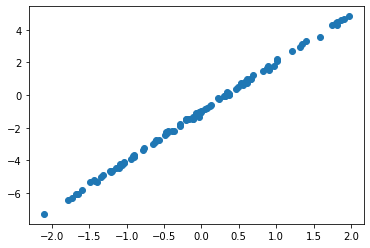

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

Therefore, our model is $\hat y(x; \theta) = wx + b$.

We will use a single array, `theta = [w, b]` to house both parameters:

In [ ]:
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

The loss function is $J(x, y; \theta) = (\hat y - y)^2$.

In [ ]:
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

How do we optimize a loss function? Using gradient descent. At each update step, we will find the gradient of the loss w.r.t. the parameters, and take a small step in the direction of steepest descent:

$\theta_{new} = \theta - 0.1 (\nabla_\theta J) (x, y; \theta)$

In [ ]:
def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

In JAX, it's common to define an `update()` function that is called every step, taking the current parameters as input and returning the new parameters. This is a natural consequence of JAX's functional nature, and is explained in more detail in [The Problem of State](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/07-state.ipynb).

This function can then be JIT-compiled in its entirety for maximum efficiency. The next guide will explain exactly how `jax.jit` works, but if you want to, you can try adding `@jax.jit` before the `update()` definition, and see how the training loop below runs much faster.

w: 3.01, b: -1.01


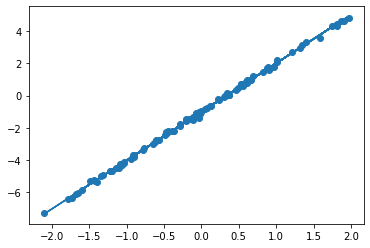

In [ ]:
theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

As you will see going through these guides, this basic recipe underlies almost all training loops you'll see implemented in JAX. The main difference between this example and real training loops is the simplicity of our model: that allows us to use a single array to house all our parameters. We cover managing more parameters in the later [pytree guide](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/05.1-pytrees.ipynb). Feel free to skip forward to that guide now to see how to manually define and train a simple MLP in JAX.